In [24]:
import os
import numpy as np
import pandas as pd
import librosa
import scipy
import matplotlib.pyplot as plt
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [25]:
%run FeedingData.ipynb
# read Calvin's function files so we can call those functions from this notebook
# list of functions: 
# mfcc_(song, n=20)
# mfcc_cut(song, n=20, cutoff = 800)
# LFCC(song, n=20)
# LFCC_no_low(song, n=20, cutoff = 800)
# LFCC_no_low_clean(song, n=20, cutoff = 800)
# mfcc_cut_cleaned(song, n=20, cutoff = 800)
# main_freq(song, cutoff = 800)

In [26]:
def get_data(audio_path, meta_file, label_name, load_length, get_feature_function):
    songs_matrix = []
    songs_label = []
    audio_list = os.listdir(audio_path)
    df = pd.read_csv(meta_file)

    for name in audio_list:
        # parse out number part of the data files so we can get the corresponding label from meta_file
        number = name.replace('_', '.').split('.')[0]
        filepath = os.path.join(audio_path, name)
        # skipping files that are less than 250KB ~ 5sec long
        # this is to make sure we have enough length for sampling fft time intervals
        if os.path.getsize(filepath) < load_length*50000:
            continue
        # ============ load the data and get matrix ============
        # replace this block with function that cleansup data and outputs a feature matrix per file
        # make sure that the size of the feature matrix is the same for all files
        # name the output feature matrix mfccs 
        song, sr = librosa.load(filepath, duration=load_length)
        features = get_feature_function(song)
        ##librosa.feature.mfcc(y = song, n_mfcc = 40)#, n_fft=512) # width of this matrix is file size in kb

        #mfcc = np.mean(mfccs, axis=1) # average over columns, shape(n_mfcc, ), used for vector input data
        # ======================================================
        songs_matrix.append(features)
        songs_label.append(df[label_name].loc[df.cat_num == float(number)].item())
    return np.array(songs_matrix), np.array(songs_label)

In [27]:
# for converting strings of label from one division to another, e.g. fam/subfam to critter name
def convert_labels(labels, meta_file, from_division, to_division):
    # find label in labels in meta_file under column from_division
    # append as key in dictionary lookup_table
    # append as value the correspondign label in to_division

    df = pd.read_csv(meta_file, usecols=[from_division, to_division])
    lookup_table = dict() # look up table for new label
    for label in labels:
        if label in lookup_table.keys():
            continue
        idx = df.loc[df[from_division]==label].index[0]
        lookup_table[label] = df[to_division][idx]
    return [lookup_table[label] for label in labels]

# example testing block
#from_division = 'fam_or_subfam'
#to_division = 'critter_name'
#meta_file = 'MLNS_Insects_Fams_05212024.csv'
#labels = ['Acrididae', 'Cicadidae', 'Acrididae', 'Listroscelidinae', 
#                  'Mogoplistinae', 'Nemobiinae', 'Oecanthinae', 'Phalangopsidae',
#                  'Phaneropterinae', 'Oecanthinae', 'Tettigoniinae','Trigonidiinae']    
#convert_labels(labels, meta_file, from_division, to_division)

In [28]:
# load all audio in audio_path
# convert to matrix, save in np array, 
# load the corresponding label_name from lable_filename, save in another np array

audio_path = '/Users/calvinyost-wolff/Documents/GitHub/chirpfiles/NoTalk'
meta_file = 'MLNS_Insects_Fams_05212024.csv'
label_name = 'fam_or_subfam'
start = time.time()
max_time = 10 # cut off time for loading, in sec
get_feature_function = main_freq
songs_matrix, songs_label = get_data(audio_path, meta_file, label_name, max_time, get_feature_function)
end = time.time()
print('time loading:', end - start)

time loading: 274.6787438392639


In [29]:
#print(songs_matrix.shape)
df_class = pd.DataFrame(np.unique(songs_label, return_counts=True)).T
print('Data read:\n', df_class)

# remove classes with too few data points
small_class_list = []
for row in range(len(df_class)):
    if df_class[1].iloc[row] < 10:
        small_class_list.append(df_class[0].iloc[row].item())
print('Removing classes:\n',small_class_list)

delete_list = []
for small_class in small_class_list:
    delete_list += list(np.where(songs_label==small_class)[0])

short_label = np.delete(songs_label, delete_list)
short_matrix = np.delete(songs_matrix, delete_list, 0)
# double check data after deleting
print('Reduced data:\n', pd.DataFrame(np.unique(short_label, return_counts=True)).T)

Data read:
                    0     1
0          Acrididae     1
1          Cicadidae    54
2     Conocephalinae   761
3       Eneopterinae    22
4          Gryllinae  1324
5     Gryllotalpidae    39
6         Hapithinae   348
7   Listroscelidinae     9
8      Mogoplistinae   248
9         Nemobiinae   317
10       Oecanthinae   589
11    Phalangopsidae    11
12   Phaneropterinae   474
13   Pseudophyllinae   133
14     Tettigoniinae   199
15     Trigonidiinae   464
Removing classes:
 ['Acrididae', 'Listroscelidinae']
Reduced data:
                   0     1
0         Cicadidae    54
1    Conocephalinae   761
2      Eneopterinae    22
3         Gryllinae  1324
4    Gryllotalpidae    39
5        Hapithinae   348
6     Mogoplistinae   248
7        Nemobiinae   317
8       Oecanthinae   589
9    Phalangopsidae    11
10  Phaneropterinae   474
11  Pseudophyllinae   133
12    Tettigoniinae   199
13    Trigonidiinae   464


In [30]:
# convert insec fam into numbers. use le.inverse_transform to go from number to name
le = LabelEncoder()
songs_label_num = le.fit_transform(short_label)

# rename data/label variable name so that we don't need to change them in the model block
data_matrix = short_matrix
data_label = songs_label_num


#scale the data
scaler = StandardScaler()
data_scale = scaler.fit_transform(data_matrix)



X_train, X_test, y_train, y_test = train_test_split(data_scale, data_label, 
                                                    test_size = .2, random_state = 404)

X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 202)
print('Train validation split train shape: ', X_tt.shape)

Train validation split train shape:  (3188, 2)


In [33]:
Ctests = [.1,1,10,100]
for i,C in enumerate(Ctests):
    print ('quadartic kernel model with C = ', C)
    start = time.time()
    model = SVC(kernel='poly', degree=2, C=C, max_iter=500000)
    model.fit(X_tt, y_tt)
    end = time.time()
    print('time training: for C = ', C, ' was ' , end - start)
    
    print('on test set')
    predicted_vector = model.predict(X_val)
    true_vector = y_val
    conf_mat = confusion_matrix(true_vector, predicted_vector)
    print(pd.DataFrame(conf_mat))#,
    #                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
    #                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
    accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
    print('accuracy =', accuracy)
    
    
    print('on training set')
    predicted_vector = model.predict(X_tt)
    true_vector = y_tt
    conf_mat = confusion_matrix(true_vector, predicted_vector)
    print(pd.DataFrame(conf_mat))#,
    #                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
    #                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
    accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
    print('training accuracy =', accuracy)
    print ('')

quadartic kernel model with C =  0.1
time training: for C =  0.1  was  0.24606990814208984
on test set
    0   1   2    3   4   5   6   7   8   9   10  11  12  13
0    0   1   0    6   0   0   0   0   0   0   0   0   0   1
1    0  64   0   16   0   0   0   0  13   0  18   0   0   7
2    0   0   0    2   0   0   0   0   1   0   0   0   0   0
3    0   7   0  209   0   0   0   0   7   0   2   0   0   2
4    0   3   0    4   0   0   0   0   1   0   0   0   0   0
5    0   5   0   46   0   0   0   0   0   0   2   0   0   4
6    0   5   0   20   0   0   0   0   1   0   0   0   0   6
7    0   5   0   33   0   0   0   0   1   0   1   0   0   2
8    0   4   0   70   0   0   0   0  20   0   1   0   0   1
9    0   0   0    2   0   0   0   0   0   0   0   0   0   1
10   0  22   0   13   0   0   0   0   4   0  36   0   0   2
11   0   2   0    9   0   0   0   0   1   0   2   0   0   0
12   0  16   0    4   0   0   0   0   3   0  17   0   0   1
13   0   3   0   56   0   0   0   0   1   0   4   0   0  

In [34]:
Ctests = [.1,1,10,100]
for i,C in enumerate(Ctests):
    print ('RBF kernel model with C = ', C)
    start = time.time()
    model = SVC(kernel='rbf', C=C, max_iter=500000)
    model.fit(X_tt, y_tt)
    end = time.time()
    print('time training: for C = ', C, ' was ' , end - start)
    
    print('on test set')
    predicted_vector = model.predict(X_val)
    true_vector = y_val
    conf_mat = confusion_matrix(true_vector, predicted_vector)
    print(pd.DataFrame(conf_mat))#,
    #                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
    #                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
    accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
    print('accuracy =', accuracy)
    
    
    print('on training set')
    predicted_vector = model.predict(X_tt)
    true_vector = y_tt
    conf_mat = confusion_matrix(true_vector, predicted_vector)
    print(pd.DataFrame(conf_mat))#,
    #                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
    #                 index = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
    accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
    print('training accuracy =', accuracy)
    print ('')

RBF kernel model with C =  0.1
time training: for C =  0.1  was  0.32825279235839844
on test set
    0   1   2    3   4   5   6   7   8   9   10  11  12  13
0    0   0   0    4   0   0   1   0   2   0   1   0   0   0
1    0  75   0    9   0   0   1   0   3   0  19   0   0  11
2    0   0   0    1   0   0   0   0   1   0   0   0   0   1
3    0  10   0  201   0   0   0   0  12   0   0   0   0   4
4    0   1   0    1   0   0   0   0   6   0   0   0   0   0
5    0   7   0   32   0   0   1   0   9   0   2   0   0   6
6    0  10   0    4   0   0   0   0   5   0   0   0   0  13
7    0   7   0   11   0   0   1   0   2   0   0   0   0  21
8    0   2   0   51   0   0   1   0  38   0   4   0   0   0
9    0   0   0    2   0   0   0   0   1   0   0   0   0   0
10   0  13   0    9   0   0   0   0  15   0  40   0   0   0
11   0   1   0    6   0   0   0   0   4   0   2   0   0   1
12   0  11   0    4   0   0   0   0   6   0  19   0   0   1
13   0  10   0   25   0   0   0   0   2   0   0   0   0  35
acc

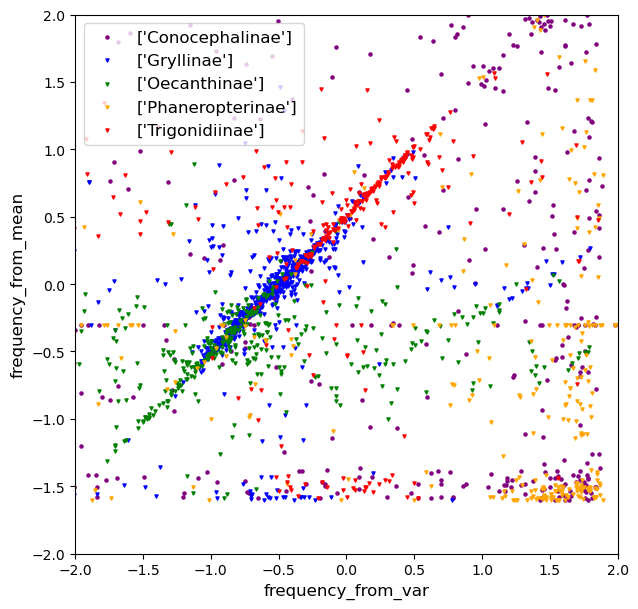

In [82]:
## Make a figure
plt.figure(figsize = (7,7))

## plot the training data
plt.scatter(X_tt[y_tt == 1,0],
            X_tt[y_tt == 1,1],
            c = "purple",
            s = 5,
            label=le.inverse_transform([1]))
plt.scatter(X_tt[y_tt == 3,0],
            X_tt[y_tt == 3,1],
            c = "blue",
            marker = 'v',
            s = 5,
            label=le.inverse_transform([3]))
plt.scatter(X_tt[y_tt == 8,0],
            X_tt[y_tt == 8,1],
            c = "green",
            marker = 'v',
            s = 5,
            label=le.inverse_transform([8]))
plt.scatter(X_tt[y_tt == 10,0],
            X_tt[y_tt == 10,1],
            c = "orange",
            marker = 'v',
            s = 5,
            label=le.inverse_transform([10]))
plt.scatter(X_tt[y_tt == 13,0],
            X_tt[y_tt == 13,1],
            c = "red",
            marker = 'v',
            s = 5,
            label=le.inverse_transform([13]))

plt.legend(fontsize=12, loc=2)

plt.xlabel("frequency_from_var",fontsize = 12)
plt.ylabel("frequency_from_mean",fontsize = 12)

plt.xlim((-2,2))
plt.ylim((-2,2))

plt.show()

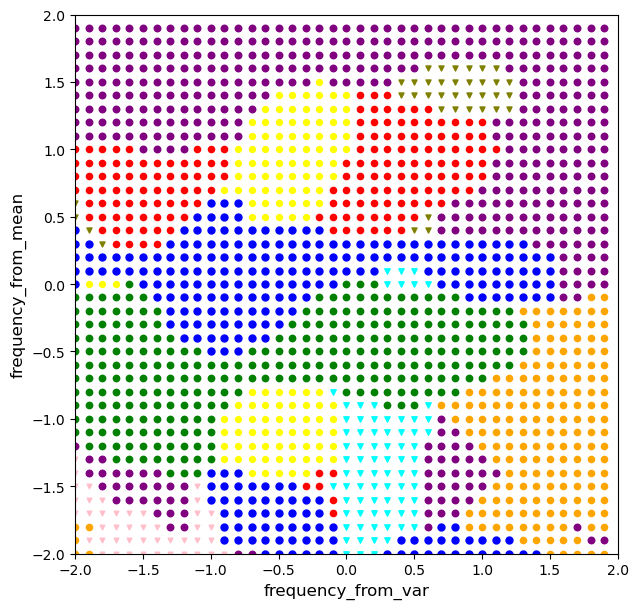

purple is  ['Conocephalinae'] ; blue is  ['Gryllinae'] ; green is  ['Oecanthinae'] ; orange is  ['Phaneropterinae']
red is  ['Trigonidiinae'] ;yellow is  ['Hapithinae'] ;cyan is  ['Mogoplistinae'] ; olive is  ['Nemobiinae'] ; pink is  ['Tettigoniinae']


In [86]:
## Make a figure
plt.figure(figsize = (7,7))

for x in range (-20,20):
    for y in range (-20,20):
        classnum = np.argmax(model.decision_function([[x/10,y/10]]))
        graph = True
        if classnum == 1:
            color = 'purple'
            mark = 'o'
            s = 17
        elif classnum == 3:
            color = 'blue'
            mark = 'o'
            s = 20
        elif classnum == 8:
            color = 'green'
            mark = 'o'
            s = 16
        elif classnum == 10:
            color = 'orange'
            mark = 'o'
            s = 15
        elif classnum == 13:
            color = 'red'
            mark = 'o'
            s = 15
        elif classnum == 5:
            color = 'yellow'
            mark = 'o'
            s = 13
        elif classnum == 6:
            color = 'cyan'
            mark = 'v'
            s = 10
        elif classnum ==7:
            color = 'olive'
            mark = 'v'
            s = 8
        elif classnum == 12:
            color = 'pink'
            mark = 'v' 
            s = 6
        else:
            graph = False
        if graph:
            plt.scatter(x/10,
            y/10,
            c = color,
            marker = mark,
            s = s+5)
plt.xlabel("frequency_from_var",fontsize = 12)
plt.ylabel("frequency_from_mean",fontsize = 12)

plt.xlim((-2,2))
plt.ylim((-2,2))

plt.show()
print ('purple is ', le.inverse_transform([1]), '; blue is ', le.inverse_transform([3]), '; green is ', le.inverse_transform([8]), '; orange is ', le.inverse_transform([10]) )
print ('red is ', le.inverse_transform([13]), ';yellow is ', le.inverse_transform([5]), ';cyan is ', le.inverse_transform([6]) , '; olive is ', le.inverse_transform([7]), '; pink is ', le.inverse_transform([12]) )

In [88]:
## to shorte list of classes after fitting on long list, use the class converter. 
pred_class = le.inverse_transform(predicted_vector)
true_class = le.inverse_transform(true_vector)

true_class_short = convert_labels(true_class, meta_file, label_name, 'critter_name')
pred_class_short = convert_labels(pred_class, meta_file, label_name, 'critter_name')
conf_mat = confusion_matrix(true_class_short, pred_class_short)
print(pd.DataFrame(conf_mat))
accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
print('accuracy =', accuracy)

   0     1    2
0  0    29    3
1  0  2007  123
2  0   314  712
accuracy = 0.8528858218318696
